# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


We want to compare SMS and email spam data. 

# SMS data

# Read data

In [3]:
sms_data=pd.read_csv('SMSspamdata.csv')
sms_data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


we also want to see the difference between number of words for spam and non spam SMS.

In [4]:
#count number of words
sms_data['NumWords'] = [len(x.split()) for x in sms_data['Message']]

In [5]:
# function to count total characters
def count_total_chars(text):
    return np.sum([len(word) for word in text.split()])

# apply the function to create a new column
sms_data['NumChars'] = sms_data["Message"].apply(count_total_chars)

In [6]:
sms_data

,Category,Message,NumWords,NumChars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,131
5568,ham,Will ü b going to esplanade fr home?,8,29
5569,ham,"Pity, * was in mood for that. So...any other s...",10,48
5570,ham,The guy did some bitching but I acted like i'd...,26,100


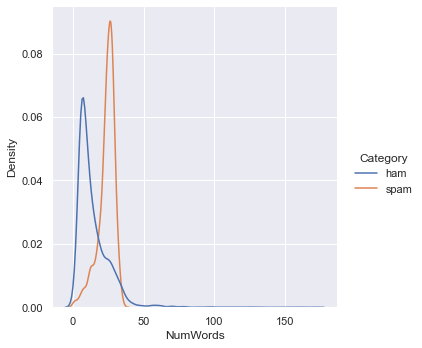

In [7]:
sns.displot(x = sms_data['NumWords'], hue= sms_data['Category'],kind='kde',common_norm=False)
plt.show()


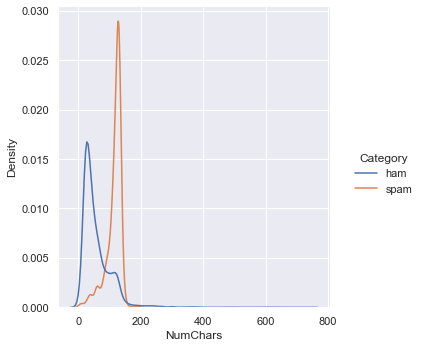

In [8]:
sns.displot(x = sms_data['NumChars'], hue= sms_data['Category'],kind='kde',common_norm=False)
plt.show()

# Text clean

In [9]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [10]:
def remove_punc(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    return re.sub(r'[^\w\s]', '', text)


In [11]:
def remove_stopwords(text):
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    return ' '.join(words)

In [12]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

In [13]:


def clean_text(data):
    #changing text to lower case
    data['Message'] = data['Message'].str.lower()
    data['Message'] = data['Message'].apply(remove_url)
    #removing punctuations
    data['Message'] = data['Message'].apply(remove_punc)
    #removing stop words
    data['Message'] = data['Message'].apply(remove_stopwords)
    #stemming
    data['Message'] = data['Message'].apply(perform_stemming)
    
    return data


In [14]:
sms_data=clean_text(sms_data)

# Train the model

In [15]:
sms_data['Category'] = sms_data['Category'].replace({'spam':0,'ham':1})

In [16]:
X = sms_data["Message"]
y = sms_data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [17]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [18]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'f1 : {f1}')

    sns.set_context('notebook', font_scale= 1.3)
    plot_confusion_matrix(y_test, y_pred, cmap= 'ocean_r')


Accuracy : 0.9757847533632287
Precision : 0.974721941354904
Recall : 0.9979296066252588
f1 : 0.9861892583120205


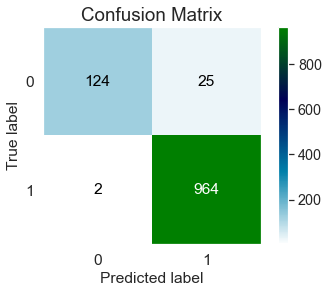

In [19]:
nb = MultinomialNB()
train_model(nb)

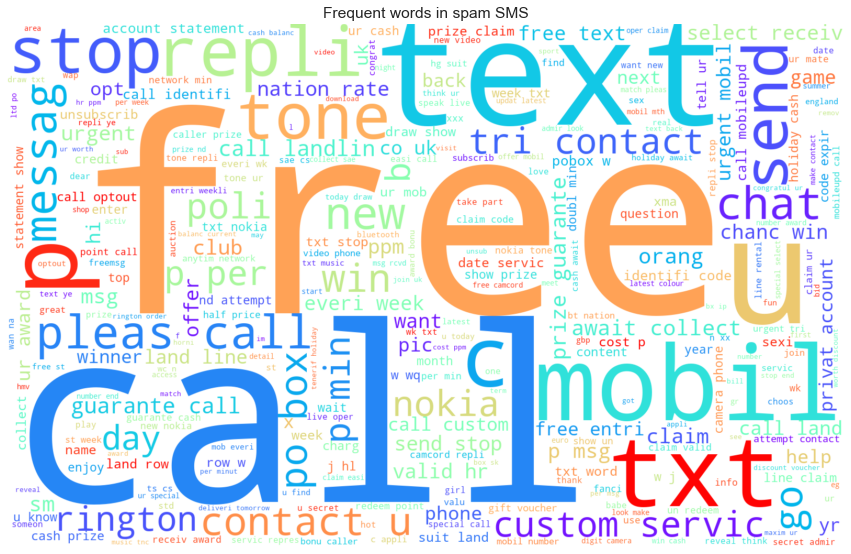

In [20]:
#Most used words in spam SMS
text = " ".join(sms_data[sms_data['Category'] == 0]['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=300, height= 1000, width = 1600,  background_color="white", colormap= 'rainbow_r').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent words in spam SMS")
plt.show()

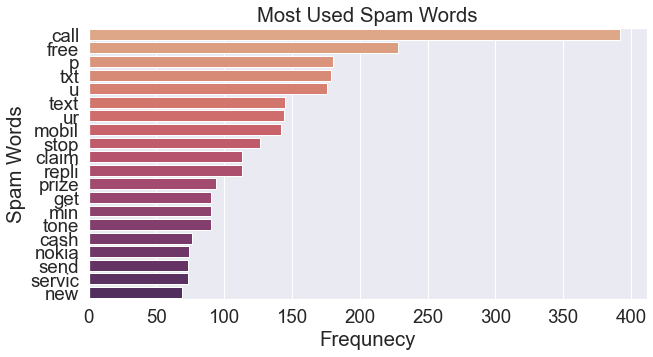

In [21]:
#Most used words in spam SMS
spam_words = []
for sentence in sms_data[sms_data['Category'] == 0]['Message'].to_list():
    for word in sentence.split():
        spam_words.append(word)

df = pd.DataFrame(Counter(spam_words).most_common(20), columns=['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.7)
plt.figure(figsize=(10,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'flare')
plt.title("Most Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()


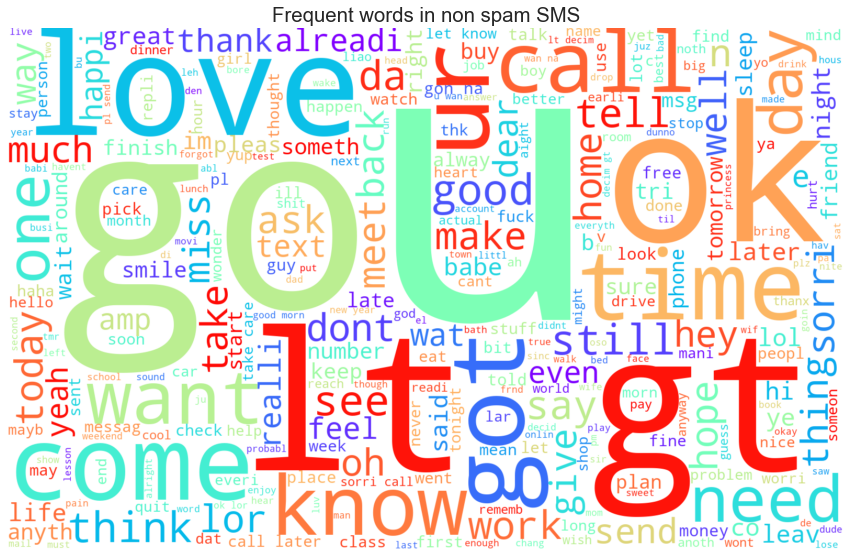

In [22]:
#Most used words in non spam SMS
text = " ".join(sms_data[sms_data['Category'] == 1]['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=300, height= 1000, width = 1600,  background_color="white", colormap= 'rainbow_r').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent words in non spam SMS")
plt.show()

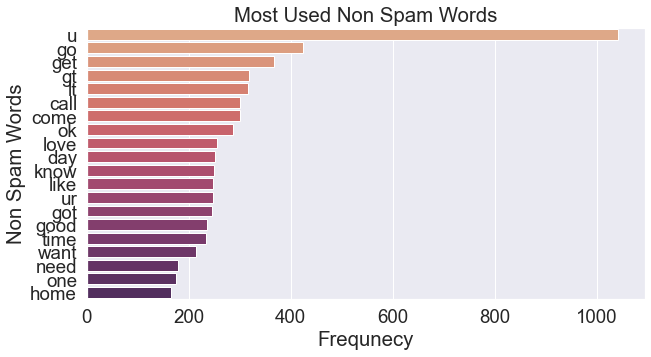

In [23]:
#Most used words in non spam SMS
non_spam_words = []
for sentence in sms_data[sms_data['Category'] == 1]['Message'].to_list():
    for word in sentence.split():
        non_spam_words.append(word)

df = pd.DataFrame(Counter(non_spam_words).most_common(20), columns=['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.7)
plt.figure(figsize=(10,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'flare')
plt.title("Most Used Non Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Non Spam Words")
plt.show()

# Email data

In [24]:
email_data=pd.read_csv('emails.csv')
email_data

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [25]:
email_data['text'] = email_data['text'].str.replace('Subject: ', '')

In [26]:
#number of words in emails.
email_data['NumWords'] = [len(x.split()) for x in email_data['text']]

# function to count total characters
def count_total_chars(text):
    return np.sum([len(word) for word in text.split()])

# apply the function to create a new column
email_data['NumChars'] = email_data["text"].apply(count_total_chars)

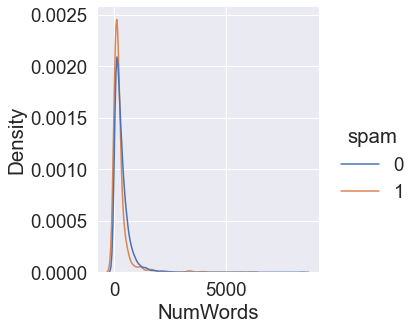

In [27]:
sns.displot(x = email_data['NumWords'], hue= email_data['spam'],kind='kde',common_norm=False)
plt.show()


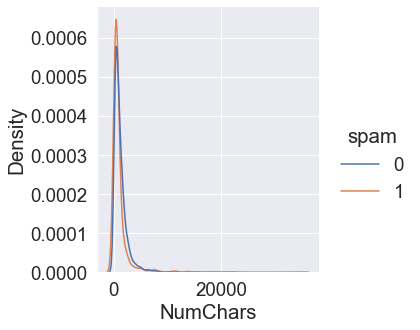

In [28]:
sns.displot(x = email_data['NumChars'], hue= email_data['spam'],kind='kde',common_norm=False)
plt.show()

In [29]:
def clean_text_email(data):
    #changing text to lower case
    data['text'] = data['text'].str.lower()
    data['text'] = data['text'].apply(remove_url)
    #removing punctuations
    data['text'] = data['text'].apply(remove_punc)
    #removing stop words
    data['text'] = data['text'].apply(remove_stopwords)
    #stemming
    data['text'] = data['text'].apply(perform_stemming)
    
    return data


In [30]:
email_data=clean_text_email(email_data)

In [31]:
email_data['text'][10]

'la vega high rise boom la vega fast becom major metropolitan citi new high rise tower expect built around la vega strip within next year condominium boom begun buy first earli phase pre construct price avail la vega high rise includ trump cosmopolitan mgm turnberri icon sky among other join interest list http www verticallv com messag sent realti one highris learn www verticallv comif wish exclud futur mail pleas repli word remov subject line'

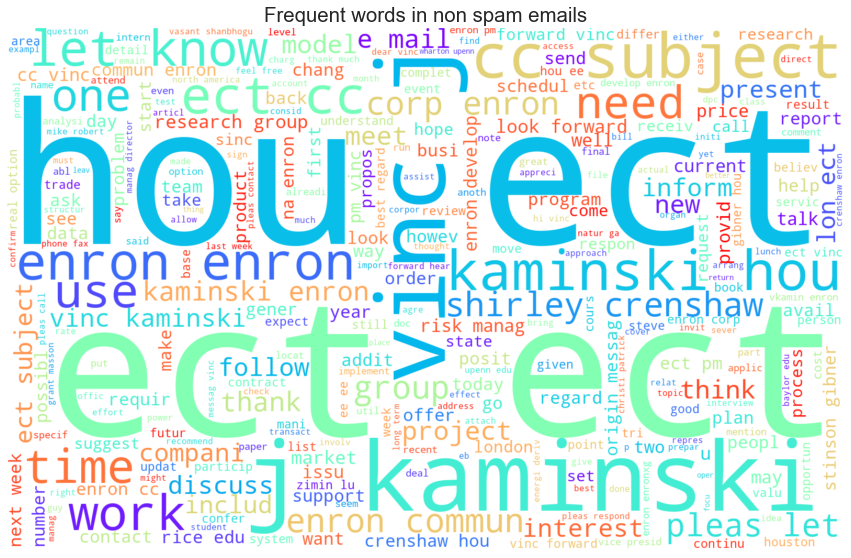

In [32]:
#Frequent words in non spam emails
text = " ".join(email_data[email_data['spam'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=300, height= 1000, width = 1600,  background_color="white", colormap= 'rainbow_r').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent words in non spam emails")
plt.show()

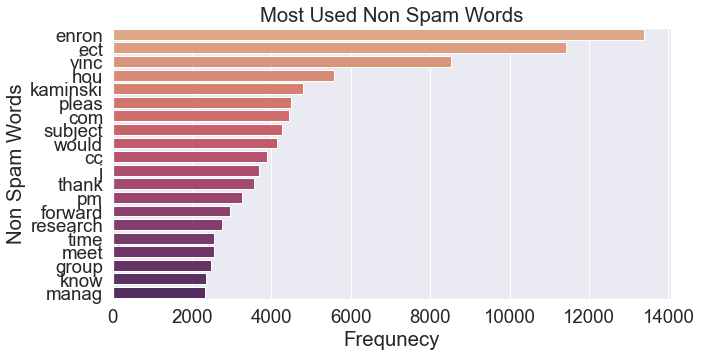

In [33]:
#Frequent words in non spam emails
non_spam_words = []
for sentence in email_data[email_data['spam'] == 0]['text'].to_list():
    for word in sentence.split():
        non_spam_words.append(word)

df = pd.DataFrame(Counter(non_spam_words).most_common(20), columns=['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.7)
plt.figure(figsize=(10,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'flare')
plt.title("Most Used Non Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Non Spam Words")
plt.show()

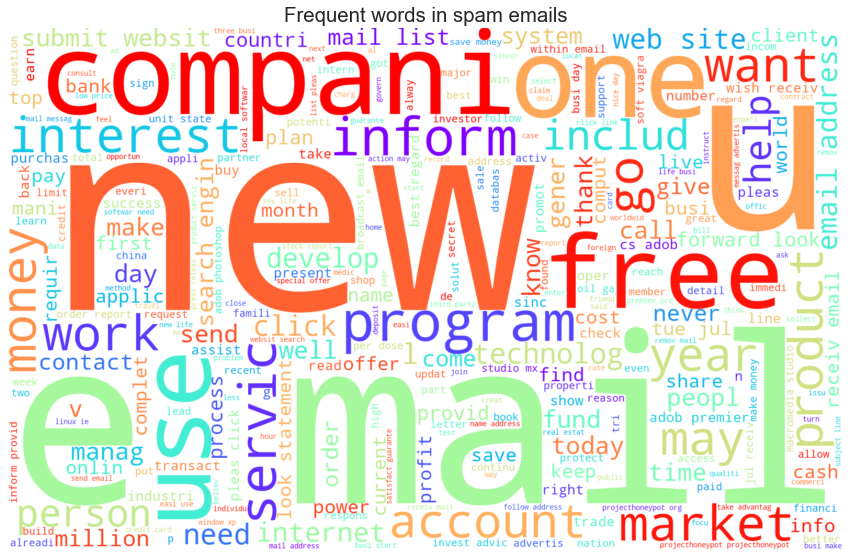

In [34]:
#Frequent words in spam emails
text = " ".join(email_data[email_data['spam'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=300, height= 1000, width = 1600,  background_color="white", colormap= 'rainbow_r').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent words in spam emails")
plt.show()

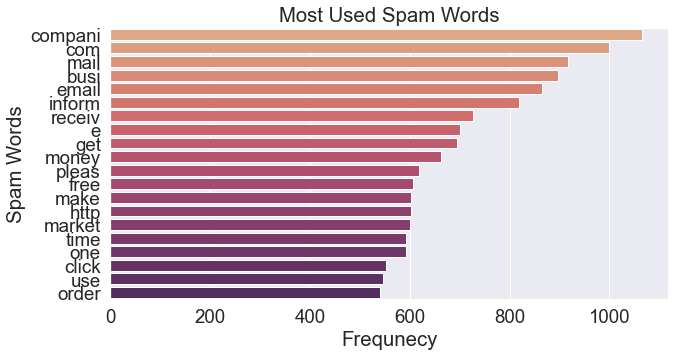

In [35]:
#Frequent words in spam emails
spam_words = []
for sentence in email_data[email_data['spam'] == 1]['text'].to_list():
    for word in sentence.split():
        spam_words.append(word)

df = pd.DataFrame(Counter(spam_words).most_common(20), columns=['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.7)
plt.figure(figsize=(10,5))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'flare')
plt.title("Most Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()


Accuracy : 0.981675392670157
Precision : 0.982078853046595
Recall : 0.9448275862068966
f1 : 0.9630931458699473


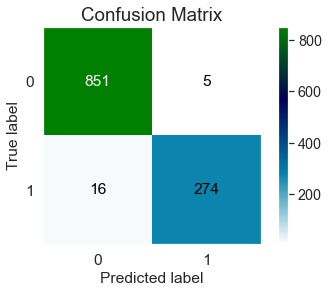

In [36]:
# Train the model
X = email_data["text"]
y = email_data['spam'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'f1 : {f1}')

    sns.set_context('notebook', font_scale= 1.3)
    plot_confusion_matrix(y_test, y_pred, cmap= 'ocean_r')


nb = MultinomialNB()
train_model(nb)